In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load CSV
df = pd.read_csv("D:/University_Course_work/StatsML-2/Deeplearning/PCA/co2_emission_PCA/Filtered_CO2.csv")

# Drop qualitative columns
df_clean = df.drop(columns=['country'])

# Drop rows with all NaNs and report how many
initial_row_count = df_clean.shape[0]
df_clean = df_clean.dropna(how='all')
rows_dropped = initial_row_count - df_clean.shape[0]
print(f"Total rows dropped due to all-NaN values: {rows_dropped}")

# Drop columns with more than 50% missing values
missing_fraction = df_clean.isnull().mean()
dropped_columns = missing_fraction[missing_fraction > 0.5].index.tolist()
df_clean = df_clean.loc[:, missing_fraction <= 0.5]

print(f"Total columns dropped due to >50% missing values: {len(dropped_columns)}")
print("Dropped columns:")
for col in dropped_columns:
    print(f"- {col}")

# Impute remaining missing values using column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_clean)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Assign column names based on df_clean
clustered_data = pd.DataFrame(X_scaled, columns=df_clean.columns)

Total rows dropped due to all-NaN values: 0
Total columns dropped due to >50% missing values: 0
Dropped columns:


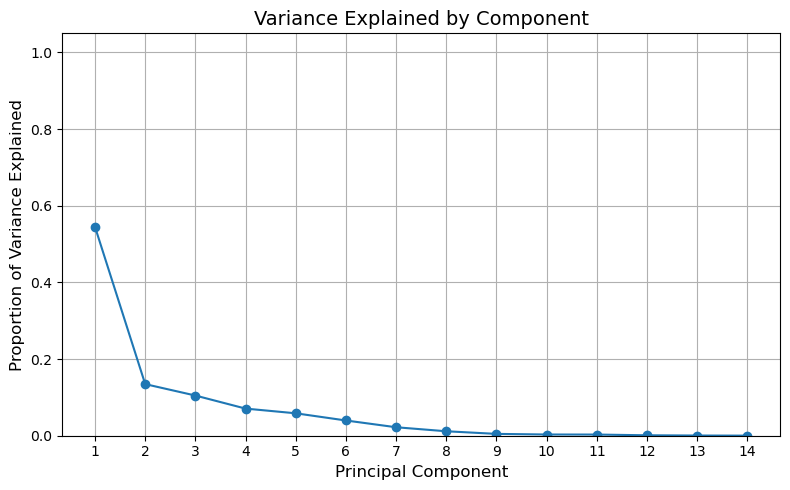

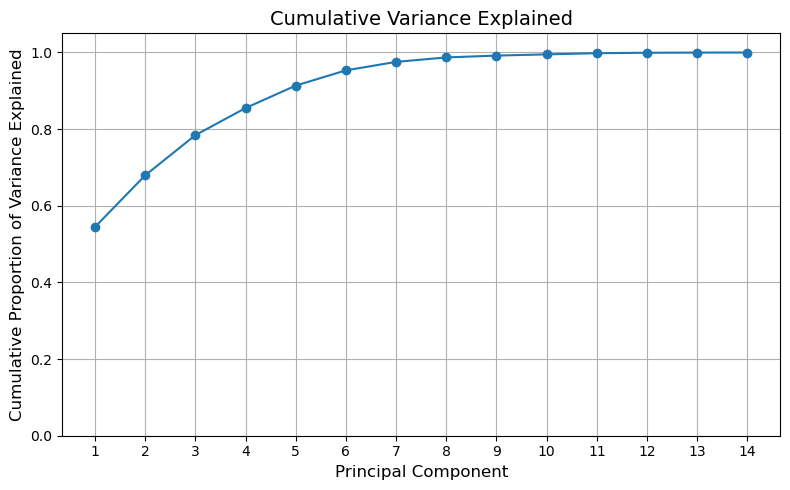

In [11]:
# 1. Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 2. Run K-Means (k=4)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), pca.explained_variance_ratio_[:14], marker='o', linestyle='-', color='tab:blue')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Proportion of Variance Explained', fontsize=12)
plt.title('Variance Explained by Component', fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(range(1, 15))
plt.grid(True)
plt.tight_layout()
plt.show()

# Cumulative proportion of variance explained (first 4 components)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), np.cumsum(pca.explained_variance_ratio_[:14]), marker='o', linestyle='-', color='tab:blue')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Cumulative Proportion of Variance Explained', fontsize=12)
plt.title('Cumulative Variance Explained', fontsize=14)
plt.ylim(0, 1.05)
plt.xticks(range(1, 15))
plt.grid(True)
plt.tight_layout()
plt.show()


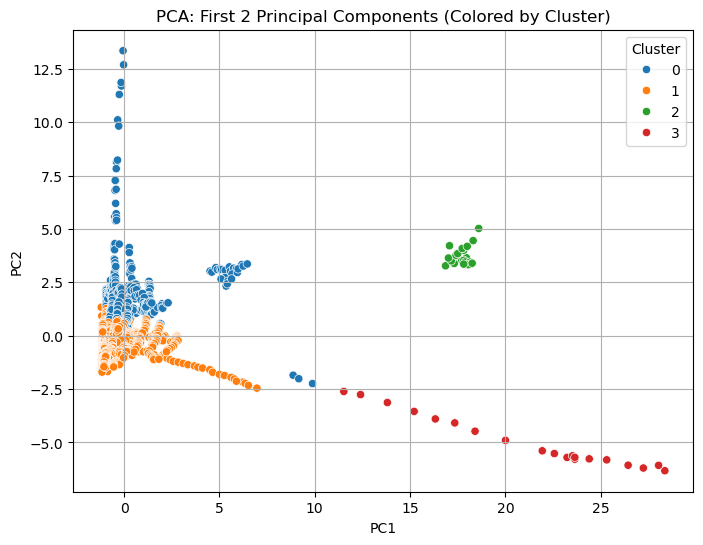

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: First 2 Principal Components (Colored by Cluster)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

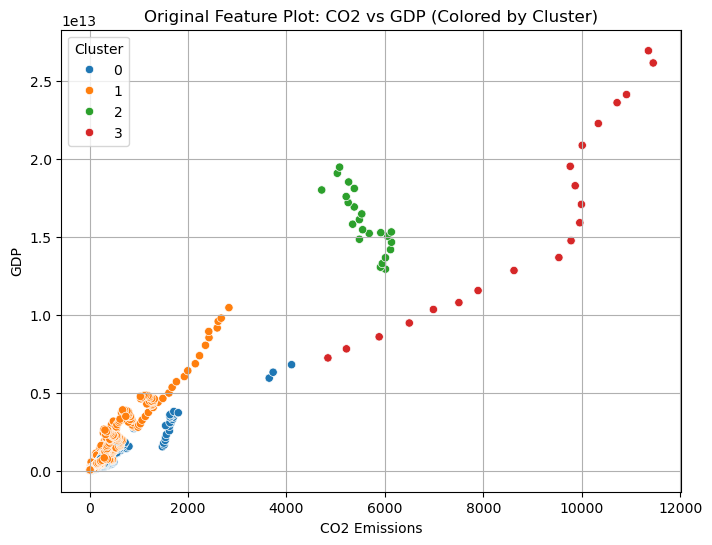

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['co2'], y=df['gdp'], hue=cluster_labels, palette='tab10')
plt.xlabel("CO2 Emissions")
plt.ylabel("GDP")
plt.title("Original Feature Plot: CO2 vs GDP (Colored by Cluster)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

The PCA plot (PC1 vs PC2) shows clear separation between country clusters, especially along PC1 — capturing major variation like GDP and emission levels. You can actually see structure emerging.

But in the raw CO2 vs GDP plot, clusters are more spread out and less distinct — harder to tell apart visually. That’s because raw features can be correlated or skewed, while PCA rotates the space to highlight meaningful variance. So PCA helps reveal patterns that aren’t obvious in the original data.

Discussion Part B

In [3]:
features = [c for c in df.columns if c not in ['country', 'year']]
X = df[features].values
X_scaled = StandardScaler().fit_transform(X)


In [4]:

U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)

# the singular values (S)
explained_var = (s**2) / np.sum(s**2)
print("First five singular values:\n", s[:5])
print("Proportion of variance explained (first five):\n", explained_var[:5])


First five singular values:
 [141.15891852  69.7197473   61.43038998  47.55799387  41.69383201]
Proportion of variance explained (first five):
 [0.5810977  0.14175687 0.11005228 0.06595984 0.05069629]



First five rows of the PC scores:
         PC1       PC2       PC3
0 -1.159524 -1.340147  0.510294
1 -1.158140 -1.347606  0.512162
2 -1.164435 -1.377719  0.541256
3 -1.162356 -1.375431  0.538347
4 -1.169830 -1.412430  0.568167


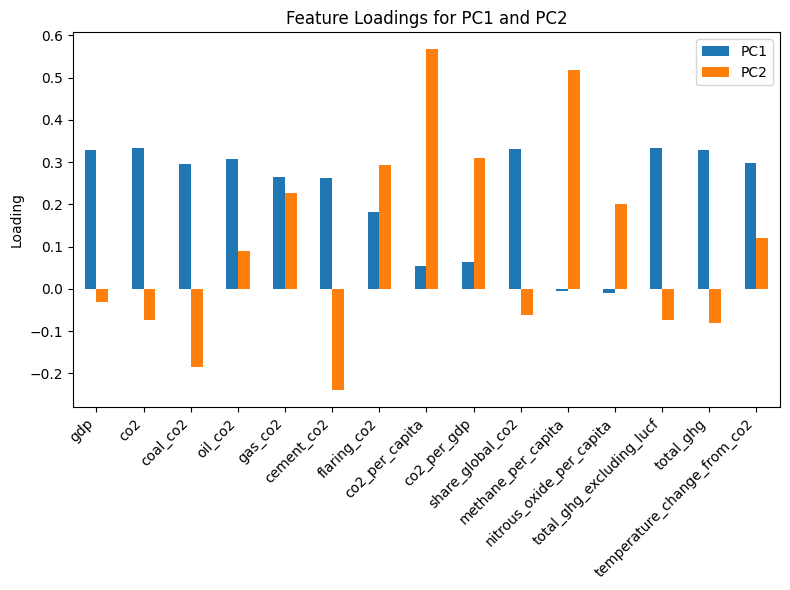

In [5]:
#the scores (U * S)
scores = U * s  # each column of U scaled by its singular value
scores_df = pd.DataFrame(scores[:, :3], columns=['PC1', 'PC2', 'PC3'])
print("\nFirst five rows of the PC scores:\n", scores_df.head())

loadings = Vt.T
loadings_df = pd.DataFrame(loadings[:, :2], index=features, columns=['PC1', 'PC2'])

# Bar chart of feature loadings for PC1 and PC2
loadings_df.plot.bar(figsize=(8, 6))
plt.title('Feature Loadings for PC1 and PC2')
plt.ylabel('Loading')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd

df = pd.read_csv("Filtered_CO2.csv")  

df = df[df['co2'].notna() & (df['co2'] >= 0)]

country_avg_co2 = df.groupby('country')['co2'].mean().reset_index()

def categorize_co2(avg):
    if avg > 6000:
        return 'High Emission'
    elif avg > 1000:
        return 'Moderately High'
    elif avg > 100:
        return 'Medium'
    elif avg > 50:
        return 'Moderately Low'
    else:
        return 'Low'

country_avg_co2['Emission Category'] = country_avg_co2['co2'].apply(categorize_co2)

for category in ['High Emission', 'Moderately High', 'Medium', 'Moderately Low', 'Low']:
    countries = country_avg_co2[country_avg_co2['Emission Category'] == category]['country'].unique()
    print(f"\n{category}:")
    print(", ".join(countries[:5]))  


High Emission:
China

Moderately High:
India, Japan, Russia, United States

Medium:
Algeria, Argentina, Australia, Belgium, Brazil

Moderately Low:
Austria, Bangladesh, Belarus, Chile, Colombia

Low:
Afghanistan, Albania, Armenia, Azerbaijan, Benin
